In [1]:
# Workaround to ensure lazy evaluation of xhistorams
# see https://github.com/xgcm/xhistogram/issues/12

import os
os.environ["NUMPY_EXPERIMENTAL_ARRAY_FUNCTION"] = "0"

# Prepare data

All trajectories are stored in a Google Cloud Storage bucket. We want to be able to load and filter all trajectories easily.  To this end, we load all the datasets (lazily), filter them to different parameters (starting MPA, depth, stokes drift), and store a Pandas dataframe with virtual sub-datasets for each combination of the parameters.  This Pandas dataframe will be pickled for later re-use.

In [2]:
# parameters
dataset_version = "v2019.09.11.2"
bucket_stokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_with_stokes.zarr"
bucket_nostokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_without_stokes.zarr"

species = {
    "Striped red mullet": {
        "settling_start_days": 25,
        "settling_end_days": 35
    },
    "White seabream": {
        "settling_start_days": 26,
        "settling_end_days": 30
    },
    "Comber": {
        "settling_start_days": 21,
        "settling_end_days": 28
    }
}

filter_warnings = "ignore"  # No warnings will bother you.  Change for debugging.

In [3]:
import warnings
warnings.filterwarnings(filter_warnings)

## Load all modules and spin up a Dask cluster

In [4]:
%matplotlib inline
from dask import array as da
import numpy as np
import xarray as xr
from gcsfs.mapping import GCSMap
from xhistogram.xarray import histogram as xhist
from matplotlib import pyplot as plt
import pandas as pd
from dask import delayed

In [5]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster.adapt(minimum=10, maximum=150, wait_count=15)

client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.5:34031 Dashboard: /user/0000-0003-1951-8494/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

## Open datasets

In [6]:
def open_dataset(bucket, restrict_to_MPA=None, restrict_to_z=None):
    # load data
    gcsmap = GCSMap(bucket)
    ds = xr.open_zarr(gcsmap, decode_cf=False)
    
    # get info on starting region and make it an easy-to-look-up coord
    initial_MPA = ds.MPA.isel(obs=0).squeeze()
    ds.coords["initial_MPA"] = initial_MPA
     
    # add mask that is False after land contact
    ds["before_land_contact"] = ((ds.land == 0).cumprod("obs") == 1)
      
    return ds

In [7]:
ds_stokes = open_dataset(bucket_stokes)
ds_nostokes = open_dataset(bucket_nostokes)

## Simplify

We know a few things about our data that make it easier to deal with them:

- No vertical migration.  Hence, initial depth of a particle is valid for all times.

- All time steps are the same. Hence, we can easily build a relative time axis that is valid for all particles.

In [8]:
def apply_assumptions(ds):
    """Applies simplifications to the dataset that are valid for the 
    specific set of experiments we're dealing with here.
    
    Be careful when applying these to new experiments, because
    they might not apply.
    """
    # We assume no vertical migration and hence
    # make (non-changing) depth level an easy to look up coord
    z = ds.z.isel(obs=0).squeeze()
    ds["z"] = z
    ds.coords["z"] = ds.z
    
    # We assume that all time steps are equal
    # and that the time axis is measured in seconds
    # since some reference period
    time_axis = ds.reset_coords(["z", "initial_MPA"]).time.isel(traj=0).squeeze()
    time_axis -= time_axis.isel(obs=0).squeeze()
    time_axis.attrs["units"] = "seconds since start of particle"
    ds.coords["time_axis"] = time_axis
    
    return ds

In [9]:
ds_stokes = apply_assumptions(ds_stokes)
ds_nostokes = apply_assumptions(ds_nostokes)

## Handle land contact

In [10]:
def mask_after_land_contact(ds):
    return ds.where(ds.before_land_contact)

In [11]:
ds_stokes_no_land_contact = mask_after_land_contact(ds_stokes)
ds_nostokes_no_land_contact = mask_after_land_contact(ds_nostokes)

## Load coordinates for quicker access

So far, we did only the bare minimum of information (data types, variable names, number of time steps, ...) but did not load any of the data.  We want to continue to do so for the bulk of the data, but get coordinates and the like now.

In [12]:
def persist_coords(ds, retries=40):
    """Will load coordinate data to the cluster."""
    ds["z"] = ds["z"].persist(retries=retries)
    ds["initial_MPA"] = ds["initial_MPA"].persist(retries=retries)
    ds["time_axis"] = ds["time_axis"].persist(retries=retries)
    return ds

In [13]:
def compute_coords(ds, retries=40):
    """Will load coordinate data to the front end."""
    ds["z"] = ds["z"].compute(retries=retries)
    ds["initial_MPA"] = ds["initial_MPA"].compute(retries=retries)
    ds["time_axis"] = ds["time_axis"].compute(retries=retries)
    return ds

In [14]:
ds_stokes = persist_coords(ds_stokes)
ds_nostokes = persist_coords(ds_nostokes)

In [15]:
ds_stokes = compute_coords(ds_stokes)
ds_nostokes = compute_coords(ds_nostokes)

In [16]:
ds_stokes_no_land_contact = compute_coords(ds_stokes_no_land_contact)
ds_nostokes_no_land_contact = compute_coords(ds_nostokes_no_land_contact)

In [17]:
ds_stokes

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 2625480)
Coordinates:
    z                    (traj) float32 1.0182366 1.0182366 ... 1.0182366
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) float64 0.0 3.6e+03 ... 3.456e+06 3.456e+06
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    distance             (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    land                 (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lat                  (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lon                  (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    temp                 (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    time      

In [18]:
ds_nostokes

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 13188600)
Coordinates:
    z                    (traj) float32 nan nan nan ... 10.536604 10.536604
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) float64 0.0 3.6e+03 ... 3.456e+06 3.456e+06
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    distance             (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    land                 (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    lat                  (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    lon                  (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    temp                 (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    t

In [19]:
ds_stokes_no_land_contact

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 2625480)
Coordinates:
    z                    (traj) float32 1.0182366 1.0182366 ... 1.0182366
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) float64 0.0 3.6e+03 ... 3.456e+06 3.456e+06
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    distance             (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    land                 (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lat                  (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lon                  (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    temp                 (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    time      

In [20]:
ds_nostokes_no_land_contact

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 13188600)
Coordinates:
    z                    (traj) float32 1.0182366 1.0182366 ... 10.536604
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) float64 0.0 3.6e+03 ... 3.456e+06 3.456e+06
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    distance             (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    land                 (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    lat                  (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    lon                  (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    temp                 (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    tim

In [21]:
def get_z_values(ds):
    """Load unique z-values to the front end.
    
    This triggers a computation across all of the z-level data.
    """
    z_values = da.unique(ds.z.data).compute(retries=40)
    z_values = z_values[~np.isnan(z_values)]
    return z_values

In [22]:
z_values = get_z_values(ds_nostokes)

In [23]:
print(z_values)

[ 1.0182366  3.1657474  5.4649634  7.9203773 10.536604 ]


## Filter data

We want to quickly select:
- stokes drift on or off
- MPA a trajectory started from
- z-level

In [24]:
def restrict_to(ds, MPA=None, z=None):
    traj_indices = xr.full_like(ds.initial_MPA, True, dtype="bool")
    
    if MPA is not None:
        traj_indices = traj_indices & (ds.initial_MPA == MPA)
    
    if z is not None:
        traj_indices = traj_indices & (ds.z == z)
        
    ds = ds.isel(traj=traj_indices)
    
    return ds

## Calculate distance histograms

This calculates time, depth and MPA resolved histograms of distance travelled.

In [25]:
# ToDo: This is relatively slow because restrict_to runs sequentially and
# on the front end.  We could speed this up by submitting the individual
# histograms to the cluster
def get_hist(ds, dist_bins=None, num_z=1):
    hist = xr.concat(
        [
            xr.concat(
                [
                    xhist(
                        restrict_to(ds, MPA=MPA, z=z_values[k]).distance,
                        bins=[dist_bins, ],
                        dim=["traj", ]
                    )
                    for k in range(num_z)
                ], dim="k"
            )
            for MPA in range(1, 10)
        ], dim="MPA"
    )
    hist.coords["MPA"] = np.arange(1, 10)
    return hist

In [26]:
hist_stokes = get_hist(ds_stokes, dist_bins=np.linspace(0, 1200, 41), num_z=1)
hist_stokes

<xarray.DataArray 'histogram_distance' (MPA: 9, k: 1, obs: 962, distance_bin: 40)>
dask.array<shape=(9, 1, 962, 40), dtype=int64, chunksize=(1, 1, 962, 40)>
Coordinates:
  * distance_bin  (distance_bin) float64 15.0 45.0 75.0 ... 1.155e+03 1.185e+03
  * MPA           (MPA) int64 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: k, obs

In [27]:
hist_stokes_no_land_contact = get_hist(ds_stokes_no_land_contact, dist_bins=np.linspace(0, 1200, 41), num_z=1)
hist_stokes_no_land_contact

<xarray.DataArray 'histogram_distance' (MPA: 9, k: 1, obs: 962, distance_bin: 40)>
dask.array<shape=(9, 1, 962, 40), dtype=int64, chunksize=(1, 1, 962, 40)>
Coordinates:
  * distance_bin  (distance_bin) float64 15.0 45.0 75.0 ... 1.155e+03 1.185e+03
  * MPA           (MPA) int64 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: k, obs

In [28]:
hist_nostokes = get_hist(ds_nostokes, dist_bins=np.linspace(0, 1200, 41), num_z=len(z_values))
hist_nostokes

<xarray.DataArray 'histogram_distance' (MPA: 9, k: 5, obs: 962, distance_bin: 40)>
dask.array<shape=(9, 5, 962, 40), dtype=int64, chunksize=(1, 1, 962, 40)>
Coordinates:
  * distance_bin  (distance_bin) float64 15.0 45.0 75.0 ... 1.155e+03 1.185e+03
  * MPA           (MPA) int64 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: k, obs

In [29]:
hist_nostokes_no_land_contact = get_hist(ds_nostokes_no_land_contact, dist_bins=np.linspace(0, 1200, 41), num_z=len(z_values))
hist_nostokes_no_land_contact

<xarray.DataArray 'histogram_distance' (MPA: 9, k: 5, obs: 962, distance_bin: 40)>
dask.array<shape=(9, 5, 962, 40), dtype=int64, chunksize=(1, 1, 962, 40)>
Coordinates:
  * distance_bin  (distance_bin) float64 15.0 45.0 75.0 ... 1.155e+03 1.185e+03
  * MPA           (MPA) int64 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: k, obs

## Plot for each species

In [30]:
def restrict_hist(hist, k=None, current_species=None):

    hist = hist.isel(k=k)  # z_levels
    if type(k) is not int:
        hist = hist.sum("k")
    hist = hist.sel(  # restrict to settling period
        obs=slice(
            24 * species[current_species]["settling_start_days"],
            24 * species[current_species]["settling_end_days"]
        )
    )
    hist = hist.sum("obs")  # sum over time
    hist = hist.squeeze()  # make sure no degenerate dims left

    hist /= hist.sum("distance_bin")  # normalize to area 1
    
    return hist

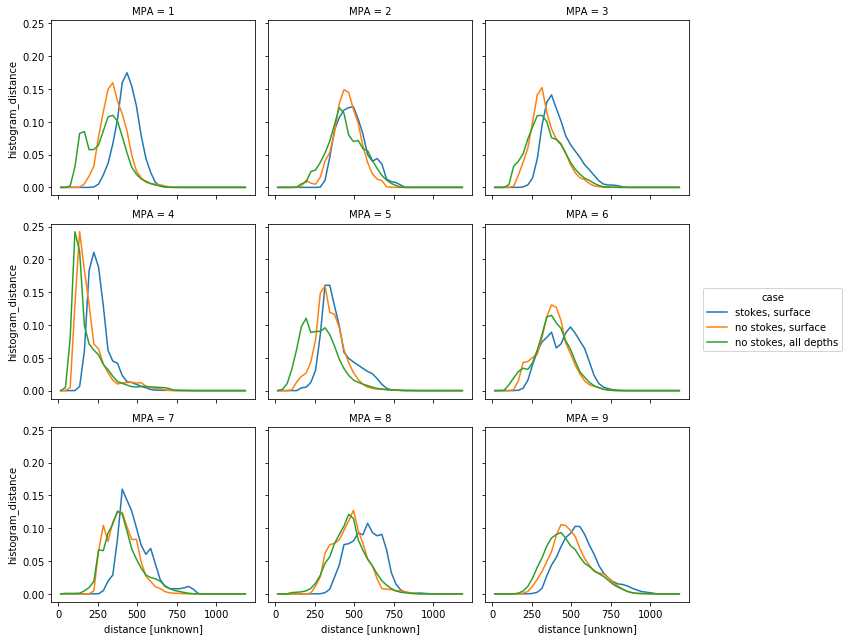

In [35]:
temp_hist = xr.concat(
    [
        restrict_hist(hist_stokes_no_land_contact, k=0, current_species="Striped red mullet"),
        restrict_hist(hist_nostokes_no_land_contact, k=0, current_species="Striped red mullet"),
        restrict_hist(hist_nostokes_no_land_contact, k=range(1, 5), current_species="Striped red mullet")
        
    ], dim="case"
)
temp_hist.coords["case"] = ["stokes, surface",
                            "no stokes, surface",
                            "no stokes, below surface"]

temp_hist.compute(retries=40).plot(
    x="distance_bin",
    col="MPA", col_wrap=3,
    hue="case"
);

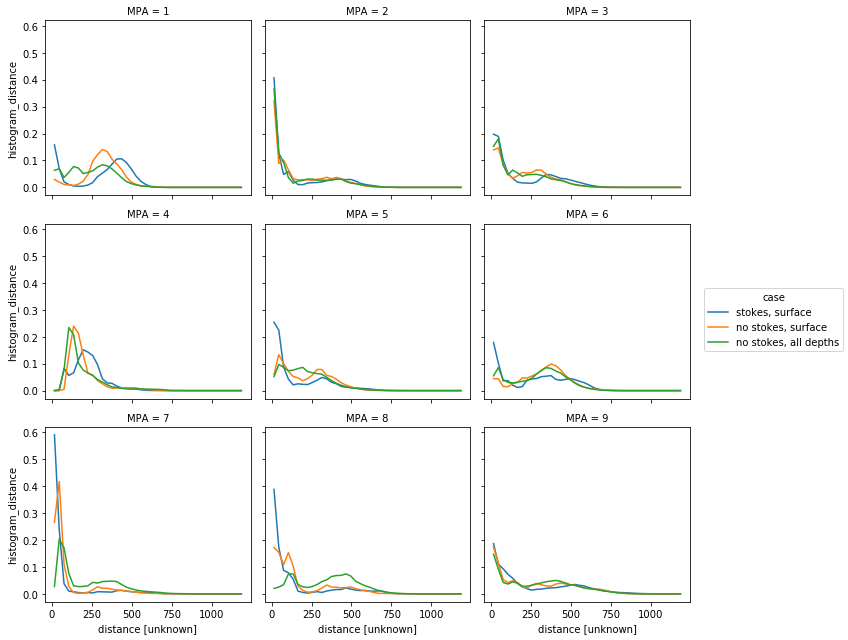

In [36]:
temp_hist = xr.concat(
    [
        restrict_hist(hist_stokes, k=0, current_species="Striped red mullet"),
        restrict_hist(hist_nostokes, k=0, current_species="Striped red mullet"),
        restrict_hist(hist_nostokes, k=range(1, 5), current_species="Striped red mullet")
        
    ], dim="case"
)
temp_hist.coords["case"] = ["stokes, surface", "no stokes, surface", "no stokes, all depths"]

temp_hist.compute(retries=40).plot(
    x="distance_bin",
    col="MPA", col_wrap=3,
    hue="case"
);

# Technical documentation

Lists the whole working environment.

In [33]:
%pip list

Package                 Version    
----------------------- -----------
absl-py                 0.8.0      
adal                    1.2.2      
affine                  2.2.2      
aiohttp                 3.5.4      
alembic                 1.1.0      
altair                  3.2.0      
antlr4-python3-runtime  4.7.2      
appdirs                 1.4.3      
asciitree               0.3.3      
asn1crypto              0.24.0     
astor                   0.7.1      
async-generator         1.10       
async-timeout           3.0.1      
attrdict                2.0.1      
attrs                   19.1.0     
backcall                0.1.0      
basemap                 1.2.1      
beautifulsoup4          4.8.0      
bleach                  3.1.0      
blinker                 1.4        
blosc                   1.8.1      
bokeh                   1.3.4      
boto3                   1.9.221    
botocore                1.12.221   
branca                  0.3.1      
cached-property         1.5.

In [34]:
%conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://repo.anaconda.com/pkgs/main/linux-64/_libgcc_mutex-0.1-main.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2019.6.16-hecc5488_0.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/libgfortran-ng-7.3.0-hdf63c60_0.conda
https://repo.anaconda.com/pkgs/main/linux-64/libstdcxx-ng-9.1.0-hdf63c60_0.conda
https://conda.anaconda.org/conda-forge/linux-64/mpi-1.0-mpich.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/pandoc-2.7.3-0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/poppler-data-0.4.9-1.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/toolchain-2.4.0-0.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/libgcc-ng-9.1.0-hdf63c60_0.conda
https://conda.anaconda.org/conda-forge/linux-64/tbb-2018.0.5-h2d50403_0.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/toolchain_c_linux-64-2.4.0-0.tar.bz2
http